# repeat processing of topo for 8k using lessons from 1/4 deg

Correct masks!

Prerequsiste: ran the model in layer mode and generated initial conditions of h

In [1]:
import xesmf
import xarray as xr
import os
import cmocean as cm
import cartopy.crs as ccrs
from dask.distributed import Client
import dask.array as da
import numpy as np
from osgeo import gdal
import matplotlib.pyplot as plt

from pyproj import Transformer
from pyproj import CRS
ps_to_ll = Transformer.from_crs( "EPSG:3031","EPSG:4326", always_xy=True) 


In [2]:
client = Client()
client

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43323 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/43323/status,
Dashboard: /proxy/43323/status,Workers: 7
Total threads: 28,Total memory: 251.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46423,Workers: 0
Dashboard: /proxy/43323/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:33855,Total threads: 4
Dashboard: /proxy/40629/status,Memory: 35.88 GiB
Nanny: tcp://127.0.0.1:32997,


In [3]:
topog = xr.open_dataset('/g/data/x77/cy8964/mom6/input/input-8km/topog_Charrassin_regridded.nc')
ice_thick = xr.open_dataset('/g/data/x77/cy8964/mom6/input/input-8km/ice_thickness_Charrassin_regridded.nc')
surface = xr.open_dataset('/g/data/x77/cy8964/mom6/input/input-8km/surface_Charrassin_regridded.nc')
water_height = xr.open_dataset('/g/data/x77/cy8964/mom6/input/input-8km/WATER_HEIGHT_Charrassin_regridded.nc')

In [49]:
# run model with topog_Charrassin_regridded_cropped.nc and layer mode to get grounding line thickness info
IceShelf_IC = xr.open_dataset('/scratch/x77/cy8964/mom6/work/panAnt_config112-gfdlexe-9125d106/IceShelf_IC_2.nc', decode_times = False)

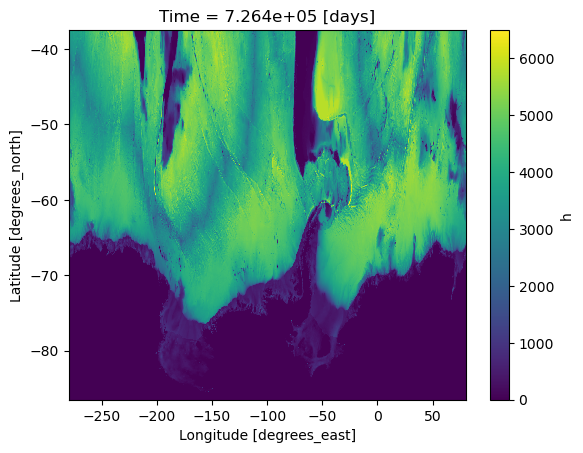

In [50]:
IceShelf_IC.h.sum('Layer').isel(Time = 0).plot()

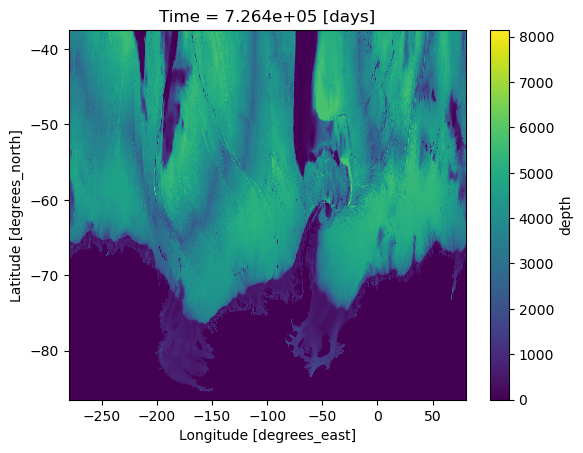

In [51]:
topog_noGL = topog.copy().sel(ny = np.arange(1442))
topog_noGL["depth"] = topog_noGL.depth.where(IceShelf_IC.h.sum('Layer').isel(Time = 0).rename({'lath':'ny','lonh':'nx'})>5).fillna(0)
topog_noGL.depth.plot()
topog_noGL.to_netcdf("/g/data/x77/cy8964/mom6/input/input-8km-SIS2/topog_Charrassin_open_cavity_noGL5m_new190825.nc")


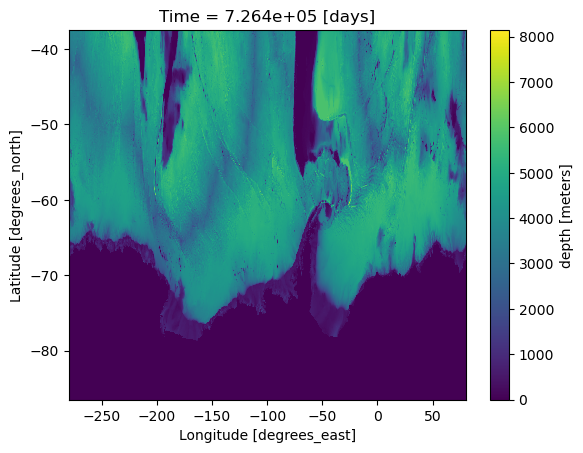

In [52]:
## define sea ice to be topog except zero where surface elevation > 0
topog_sea_ice = topog.copy().sel(ny = np.arange(1442))
topog_sea_ice["depth"] = topog_sea_ice.depth.where(surface.elevation.sel(ny = np.arange(1442))==0).fillna(0)
topog_sea_ice["depth"] = topog_sea_ice.depth.where(topog_sea_ice.depth > 0).fillna(0)
topog_sea_ice["depth"] = topog_sea_ice.depth.where(IceShelf_IC.h.sum('Layer').isel(Time = 0).rename({'lath':'ny','lonh':'nx'})>5).fillna(0)

topog_sea_ice = topog_sea_ice
topog_sea_ice.depth.attrs = {'units':"meters"}
topog_sea_ice.depth.plot()
topog_sea_ice.to_netcdf("/g/data/x77/cy8964/mom6/input/input-8km-SIS2/topog_Charrassin_sea_ice_from_iceelev_no_edits_new190825.nc")


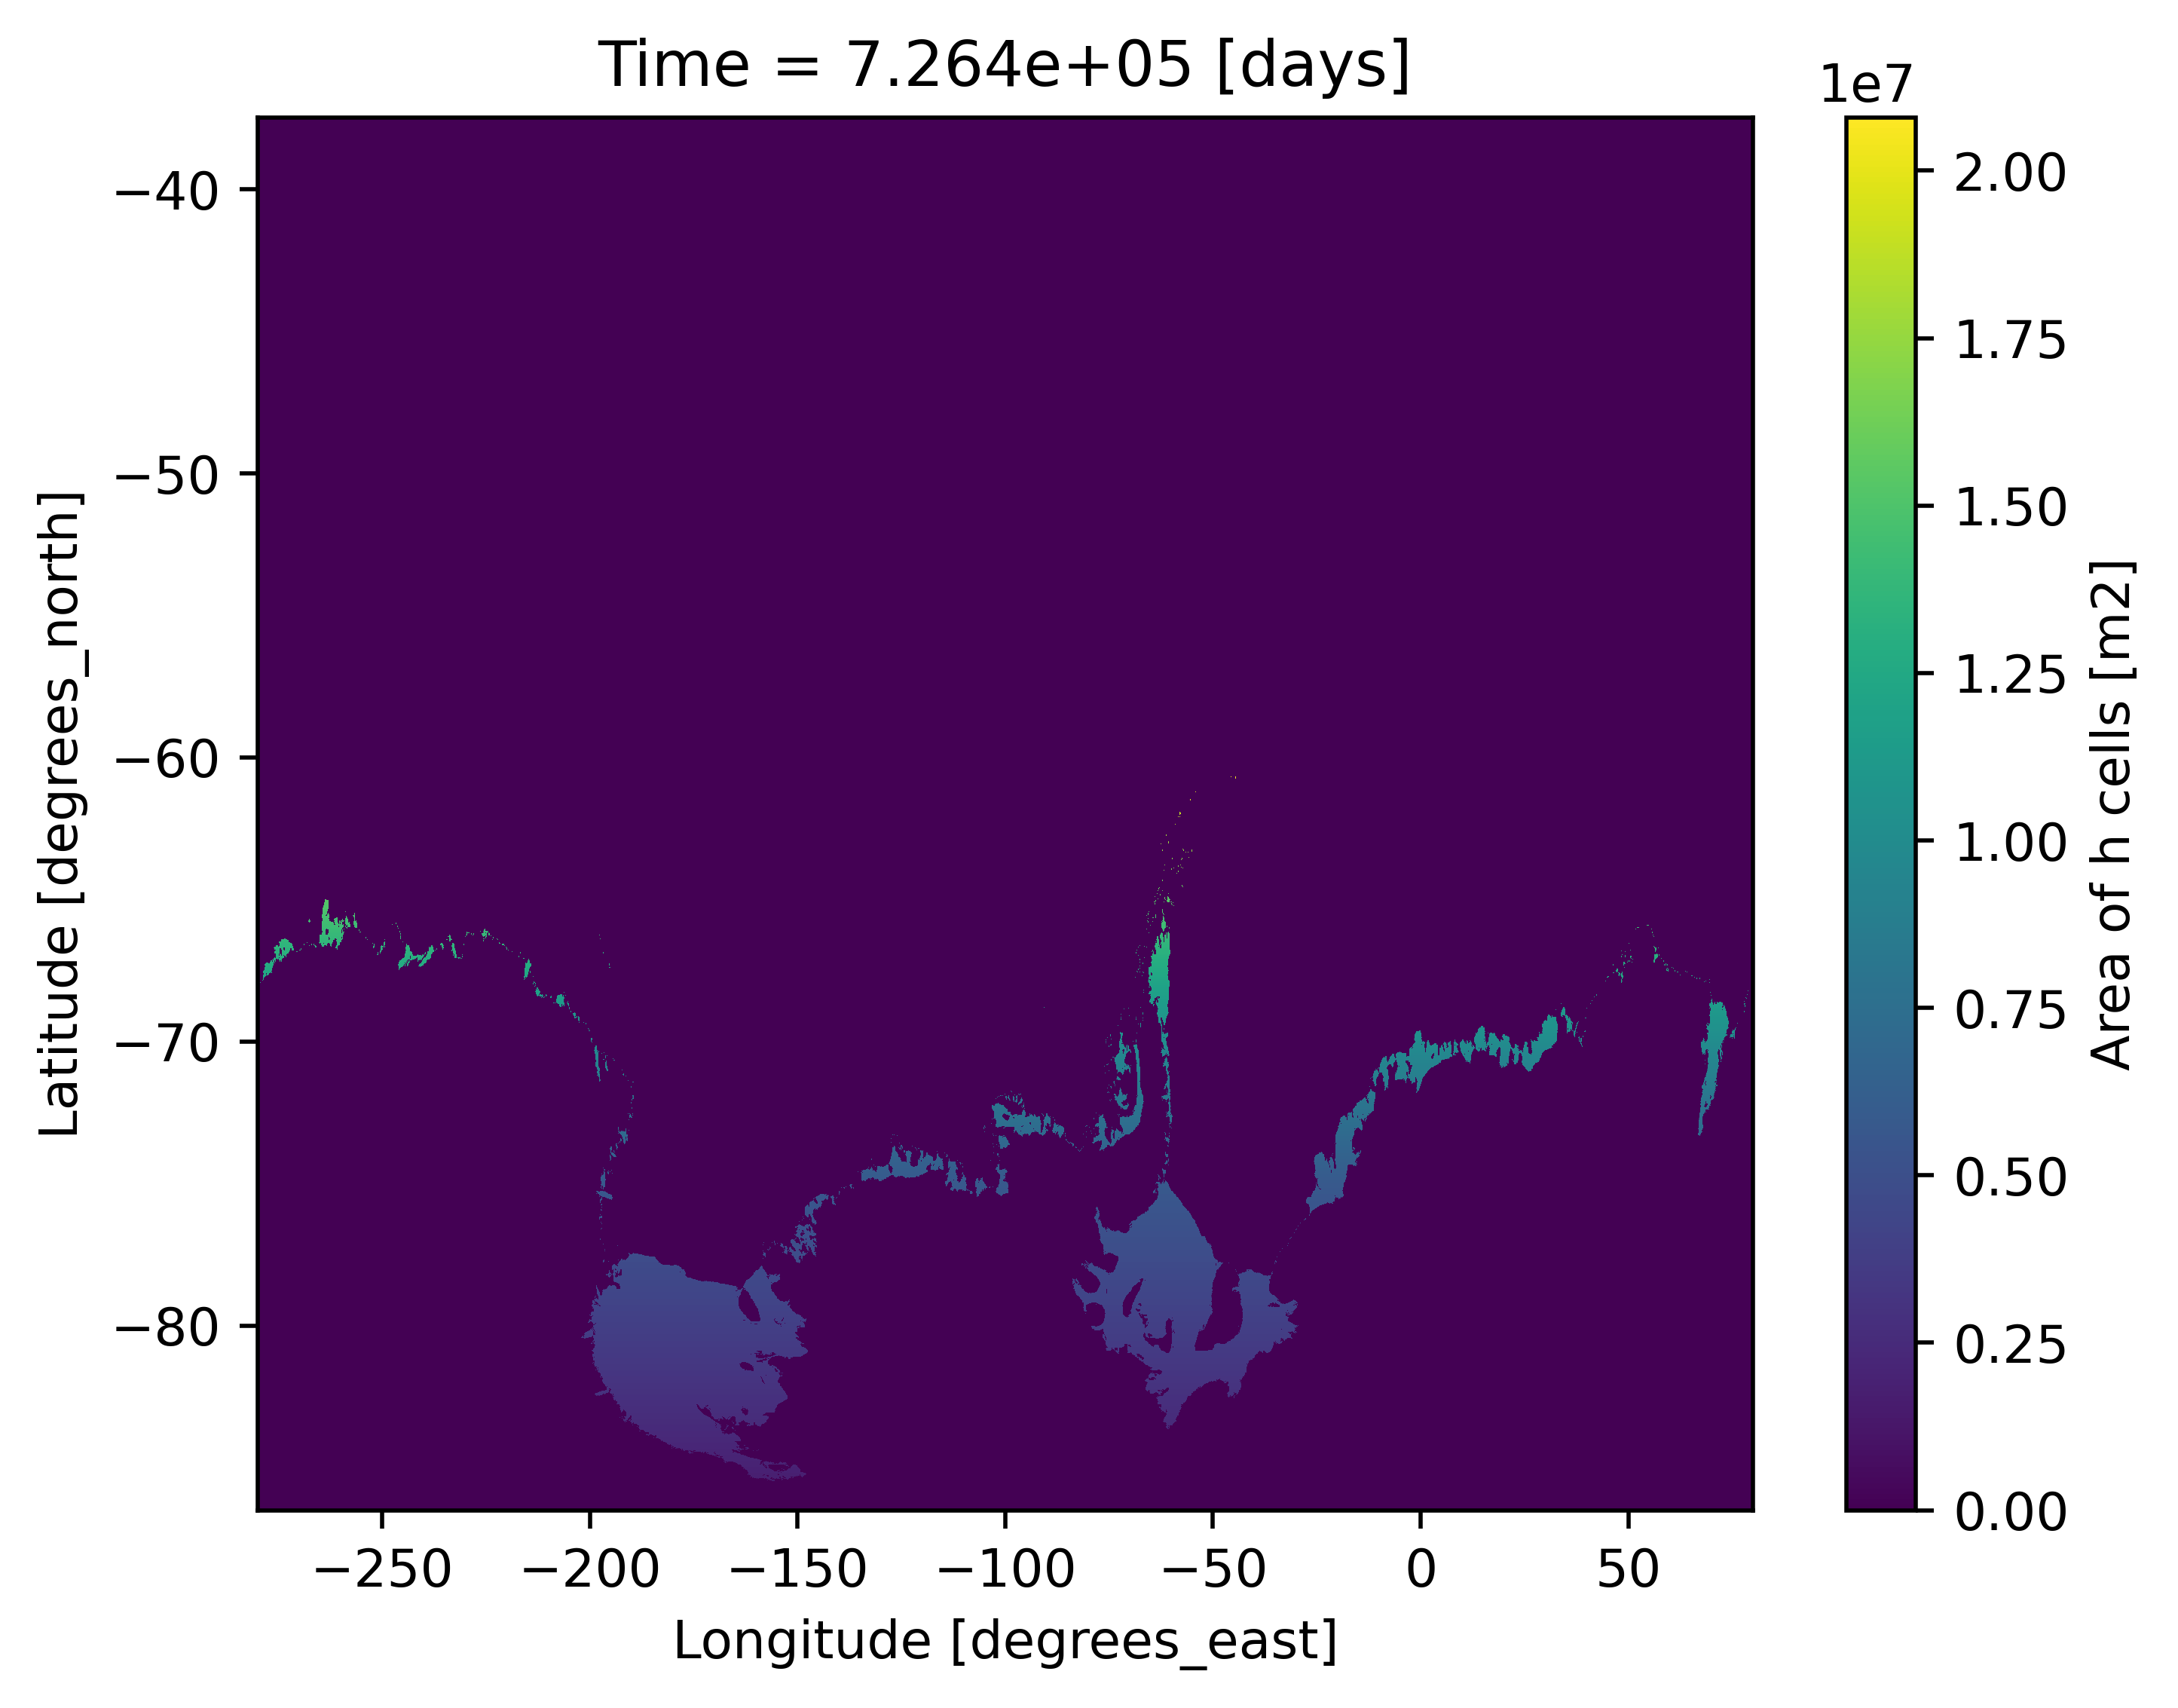

In [53]:
ice_thick_area_GL = ice_thick.copy().sel(ny = np.arange(1442))
ice_thick_area_GL["area"] = area.Ah.rename({'lath':'ny','lonh':'nx'}).where(surface.elevation.sel(ny = np.arange(1442))>0).fillna(0)
ice_thick_area_GL["area"] = ice_thick_area_GL.area.where(IceShelf_IC.h.sum('Layer').isel(Time = 0).rename({'lath':'ny','lonh':'nx'})>5).fillna(0)
ice_thick_area_GL["thick"] = ice_thick_area_GL.thick.where(IceShelf_IC.h.sum('Layer').isel(Time = 0).rename({'lath':'ny','lonh':'nx'})>5).fillna(0)

fig = plt.figure(dpi = 500)
ice_thick_area_GL.area.plot()
ice_thick_area_GL.to_netcdf("/g/data/x77/cy8964/mom6/input/input-8km-SIS2/ice_thickness_Charrassin_regridded_cropped_add_area_where_iceelev_noGL5m_new190825.nc")


In [15]:
area = xr.open_dataset('/g/data/x77/cy8964/mom6/input/input-8km-SIS2/area_everywhere.nc')
topo = xr.open_dataset('/g/data/x77/cy8964/mom6/input/input-8km-SIS2/topog_Charrassin_open_cavity_noGL5m_new190825.nc',
                      decode_timedelta = False)
# use this as a mask for where ocean thick greater than 0

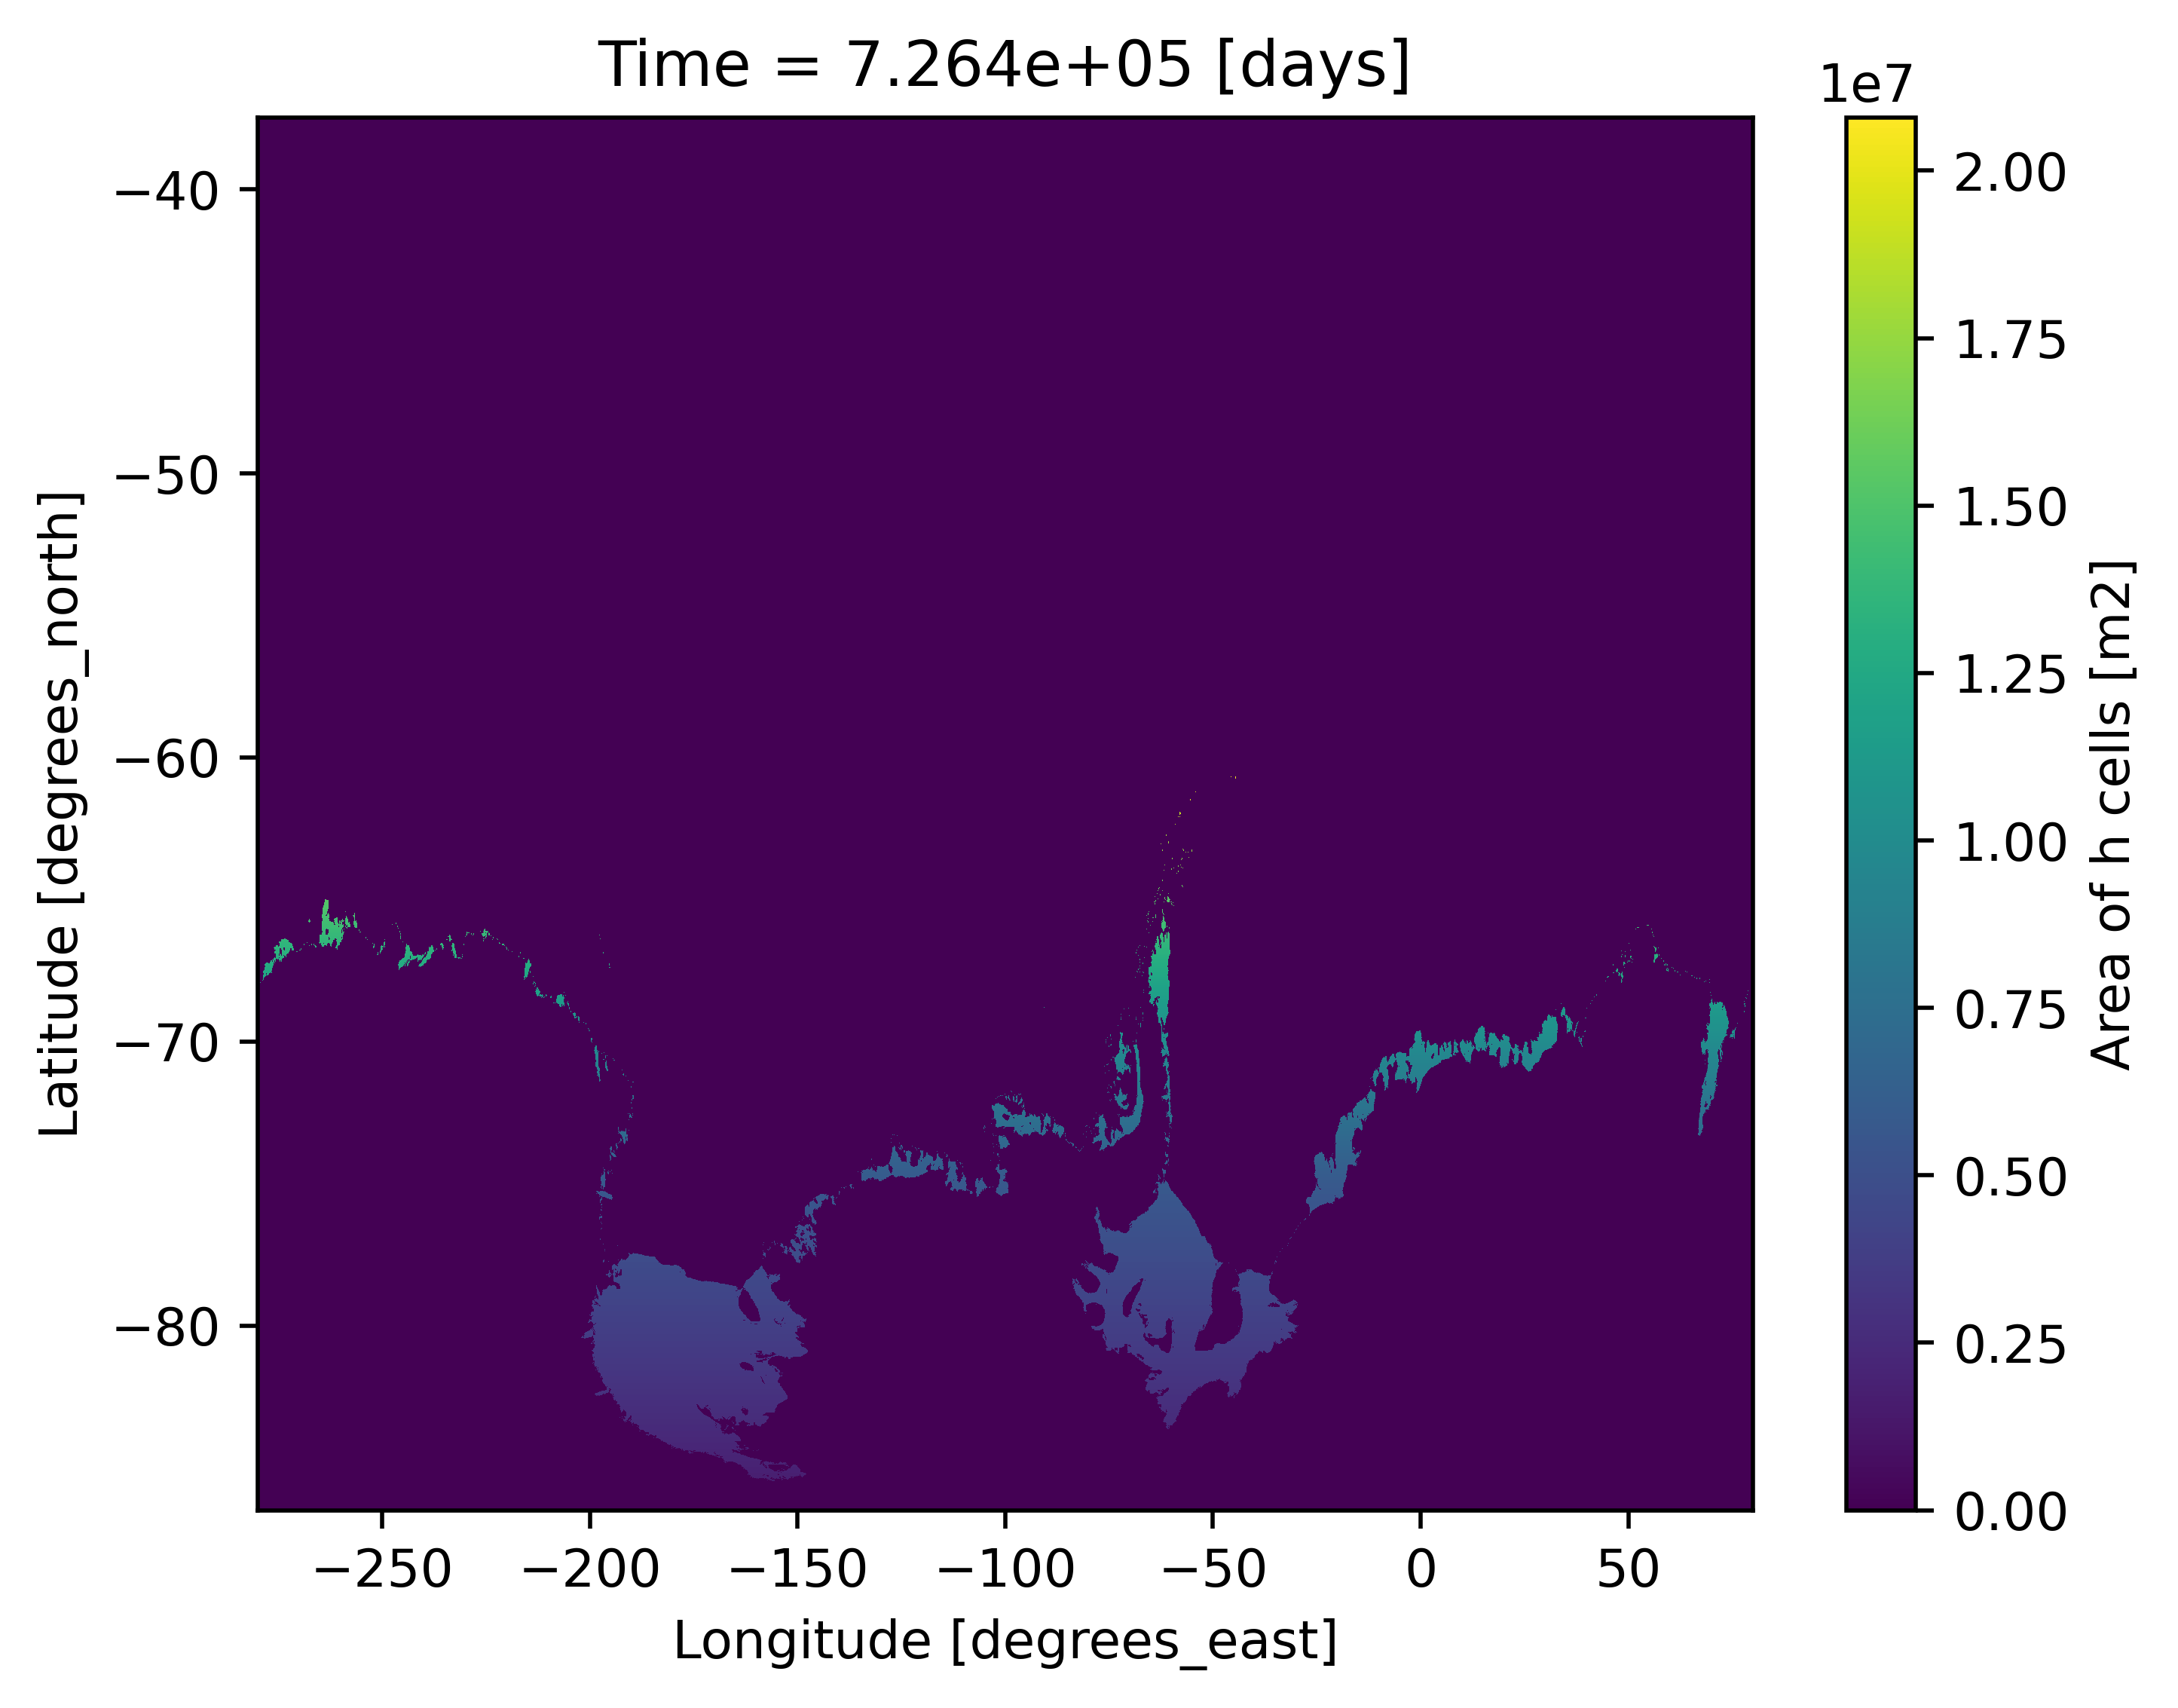

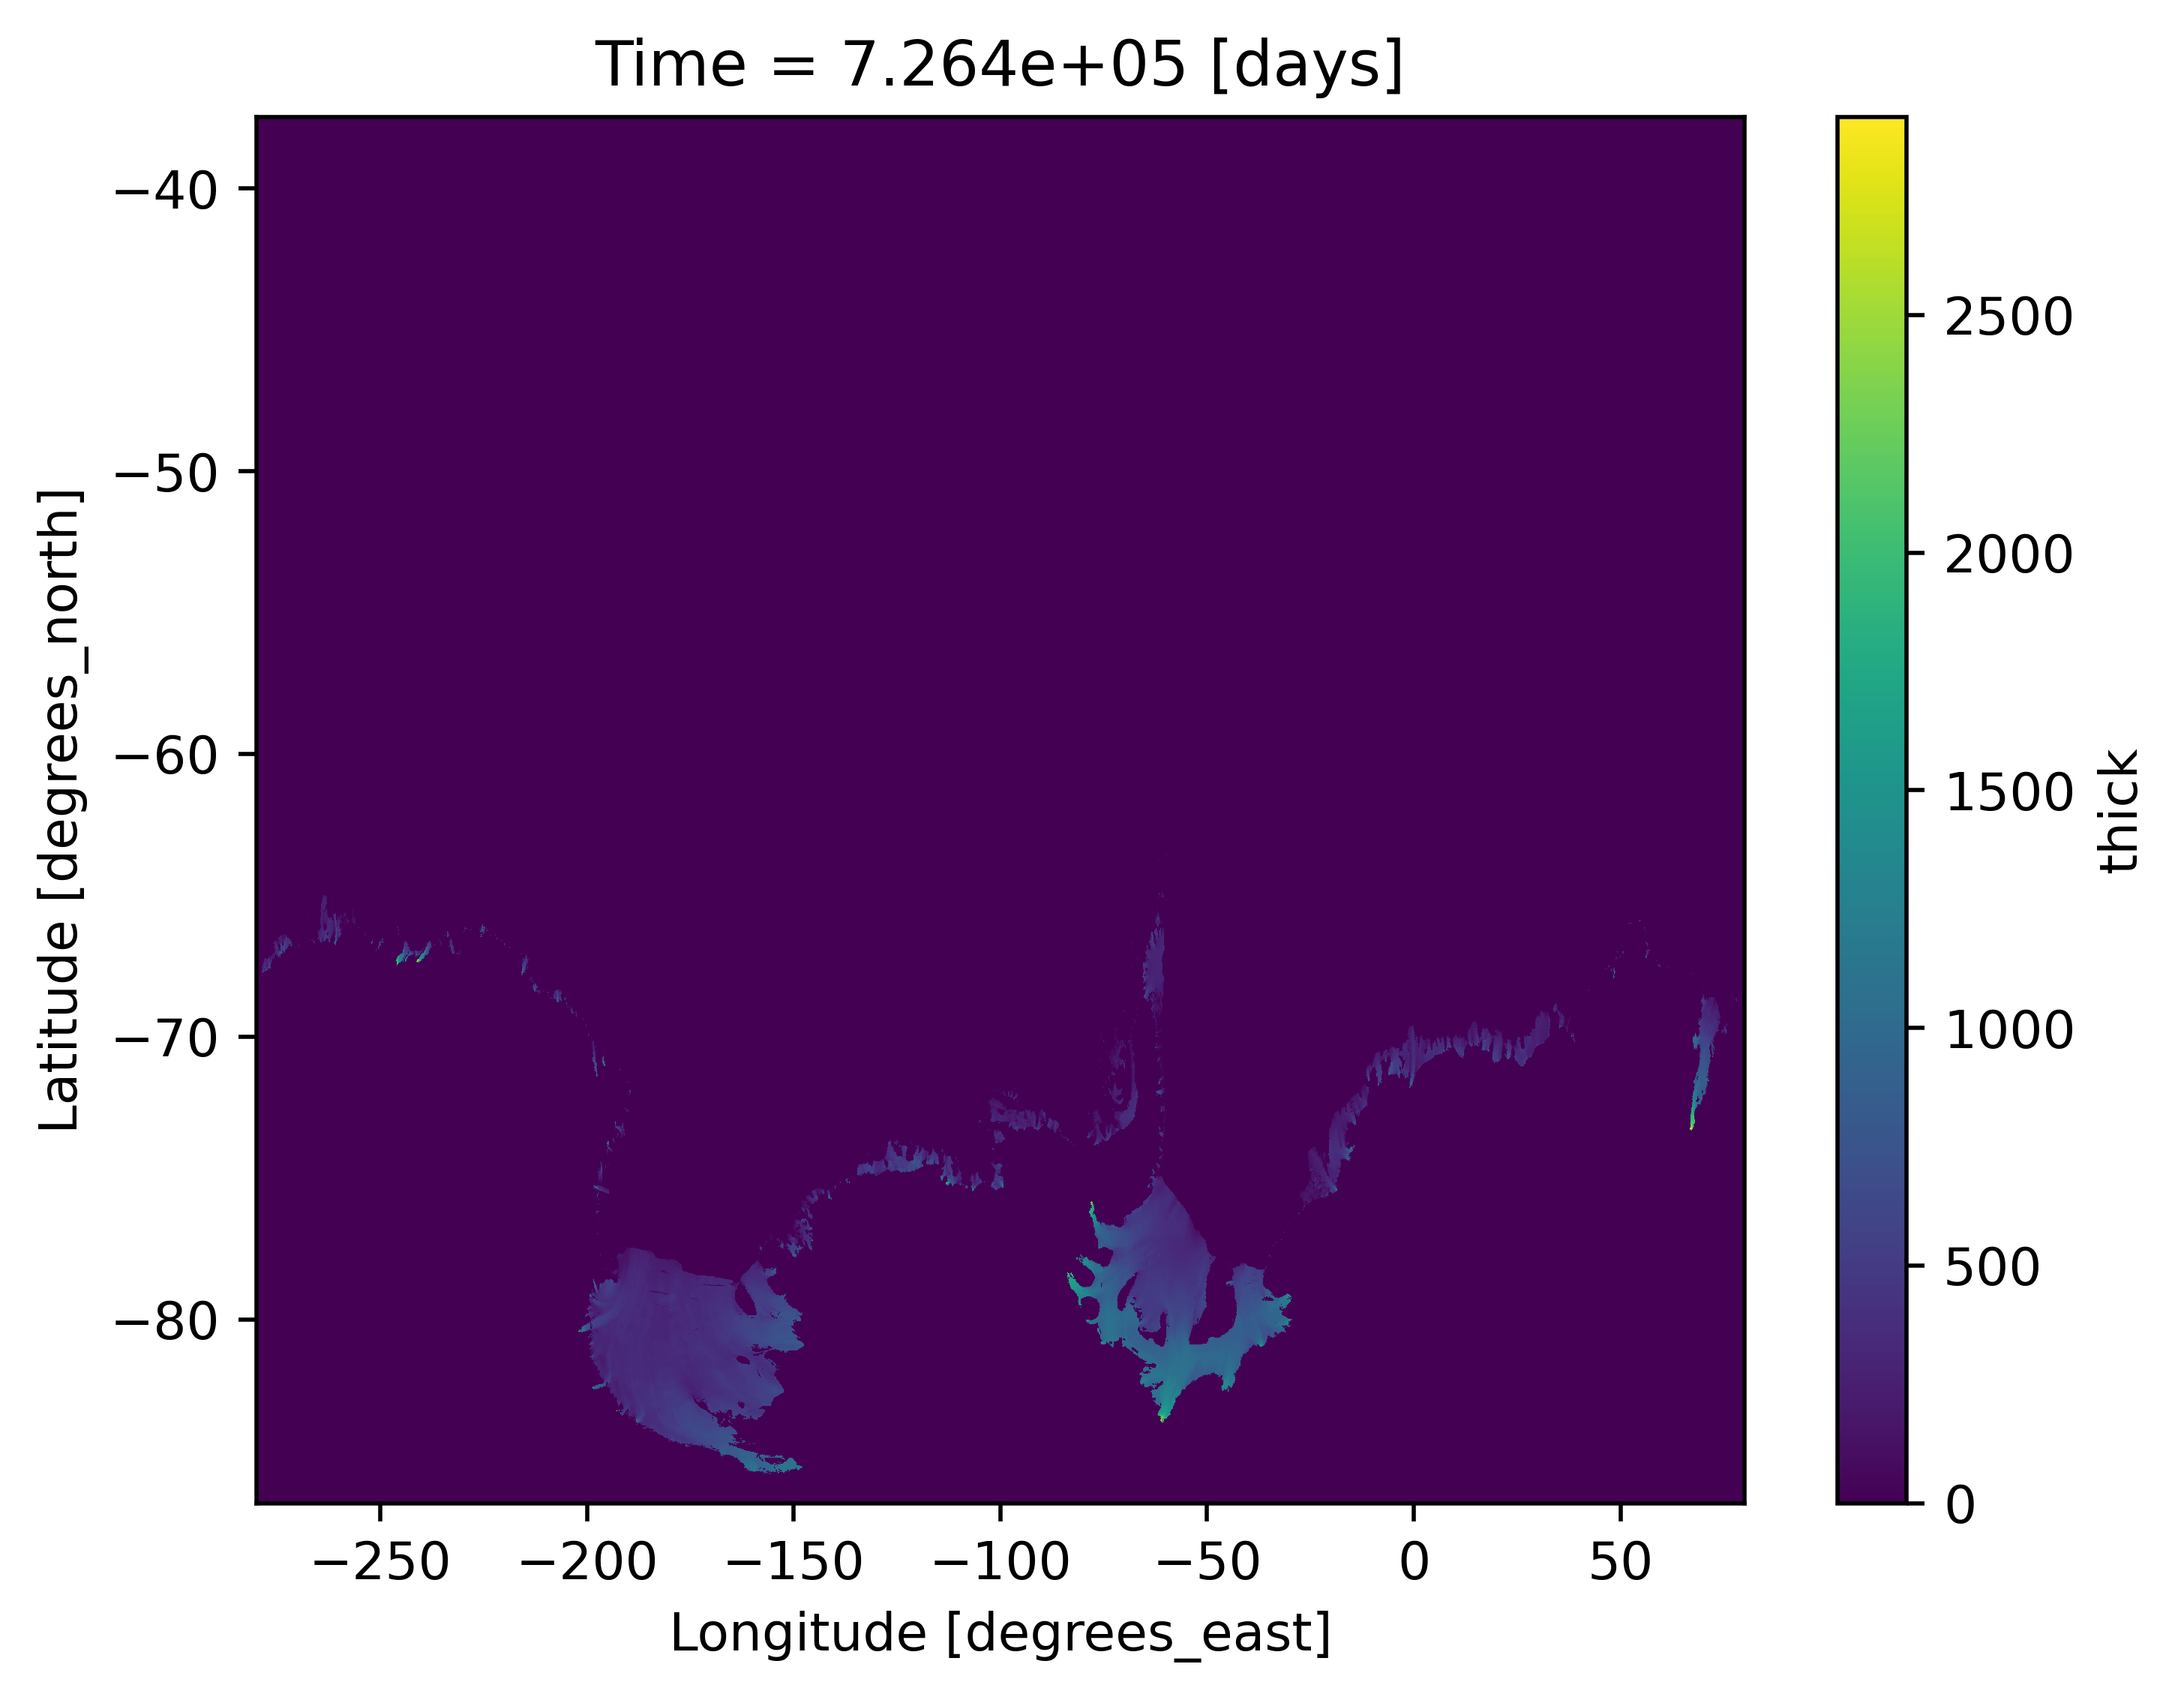

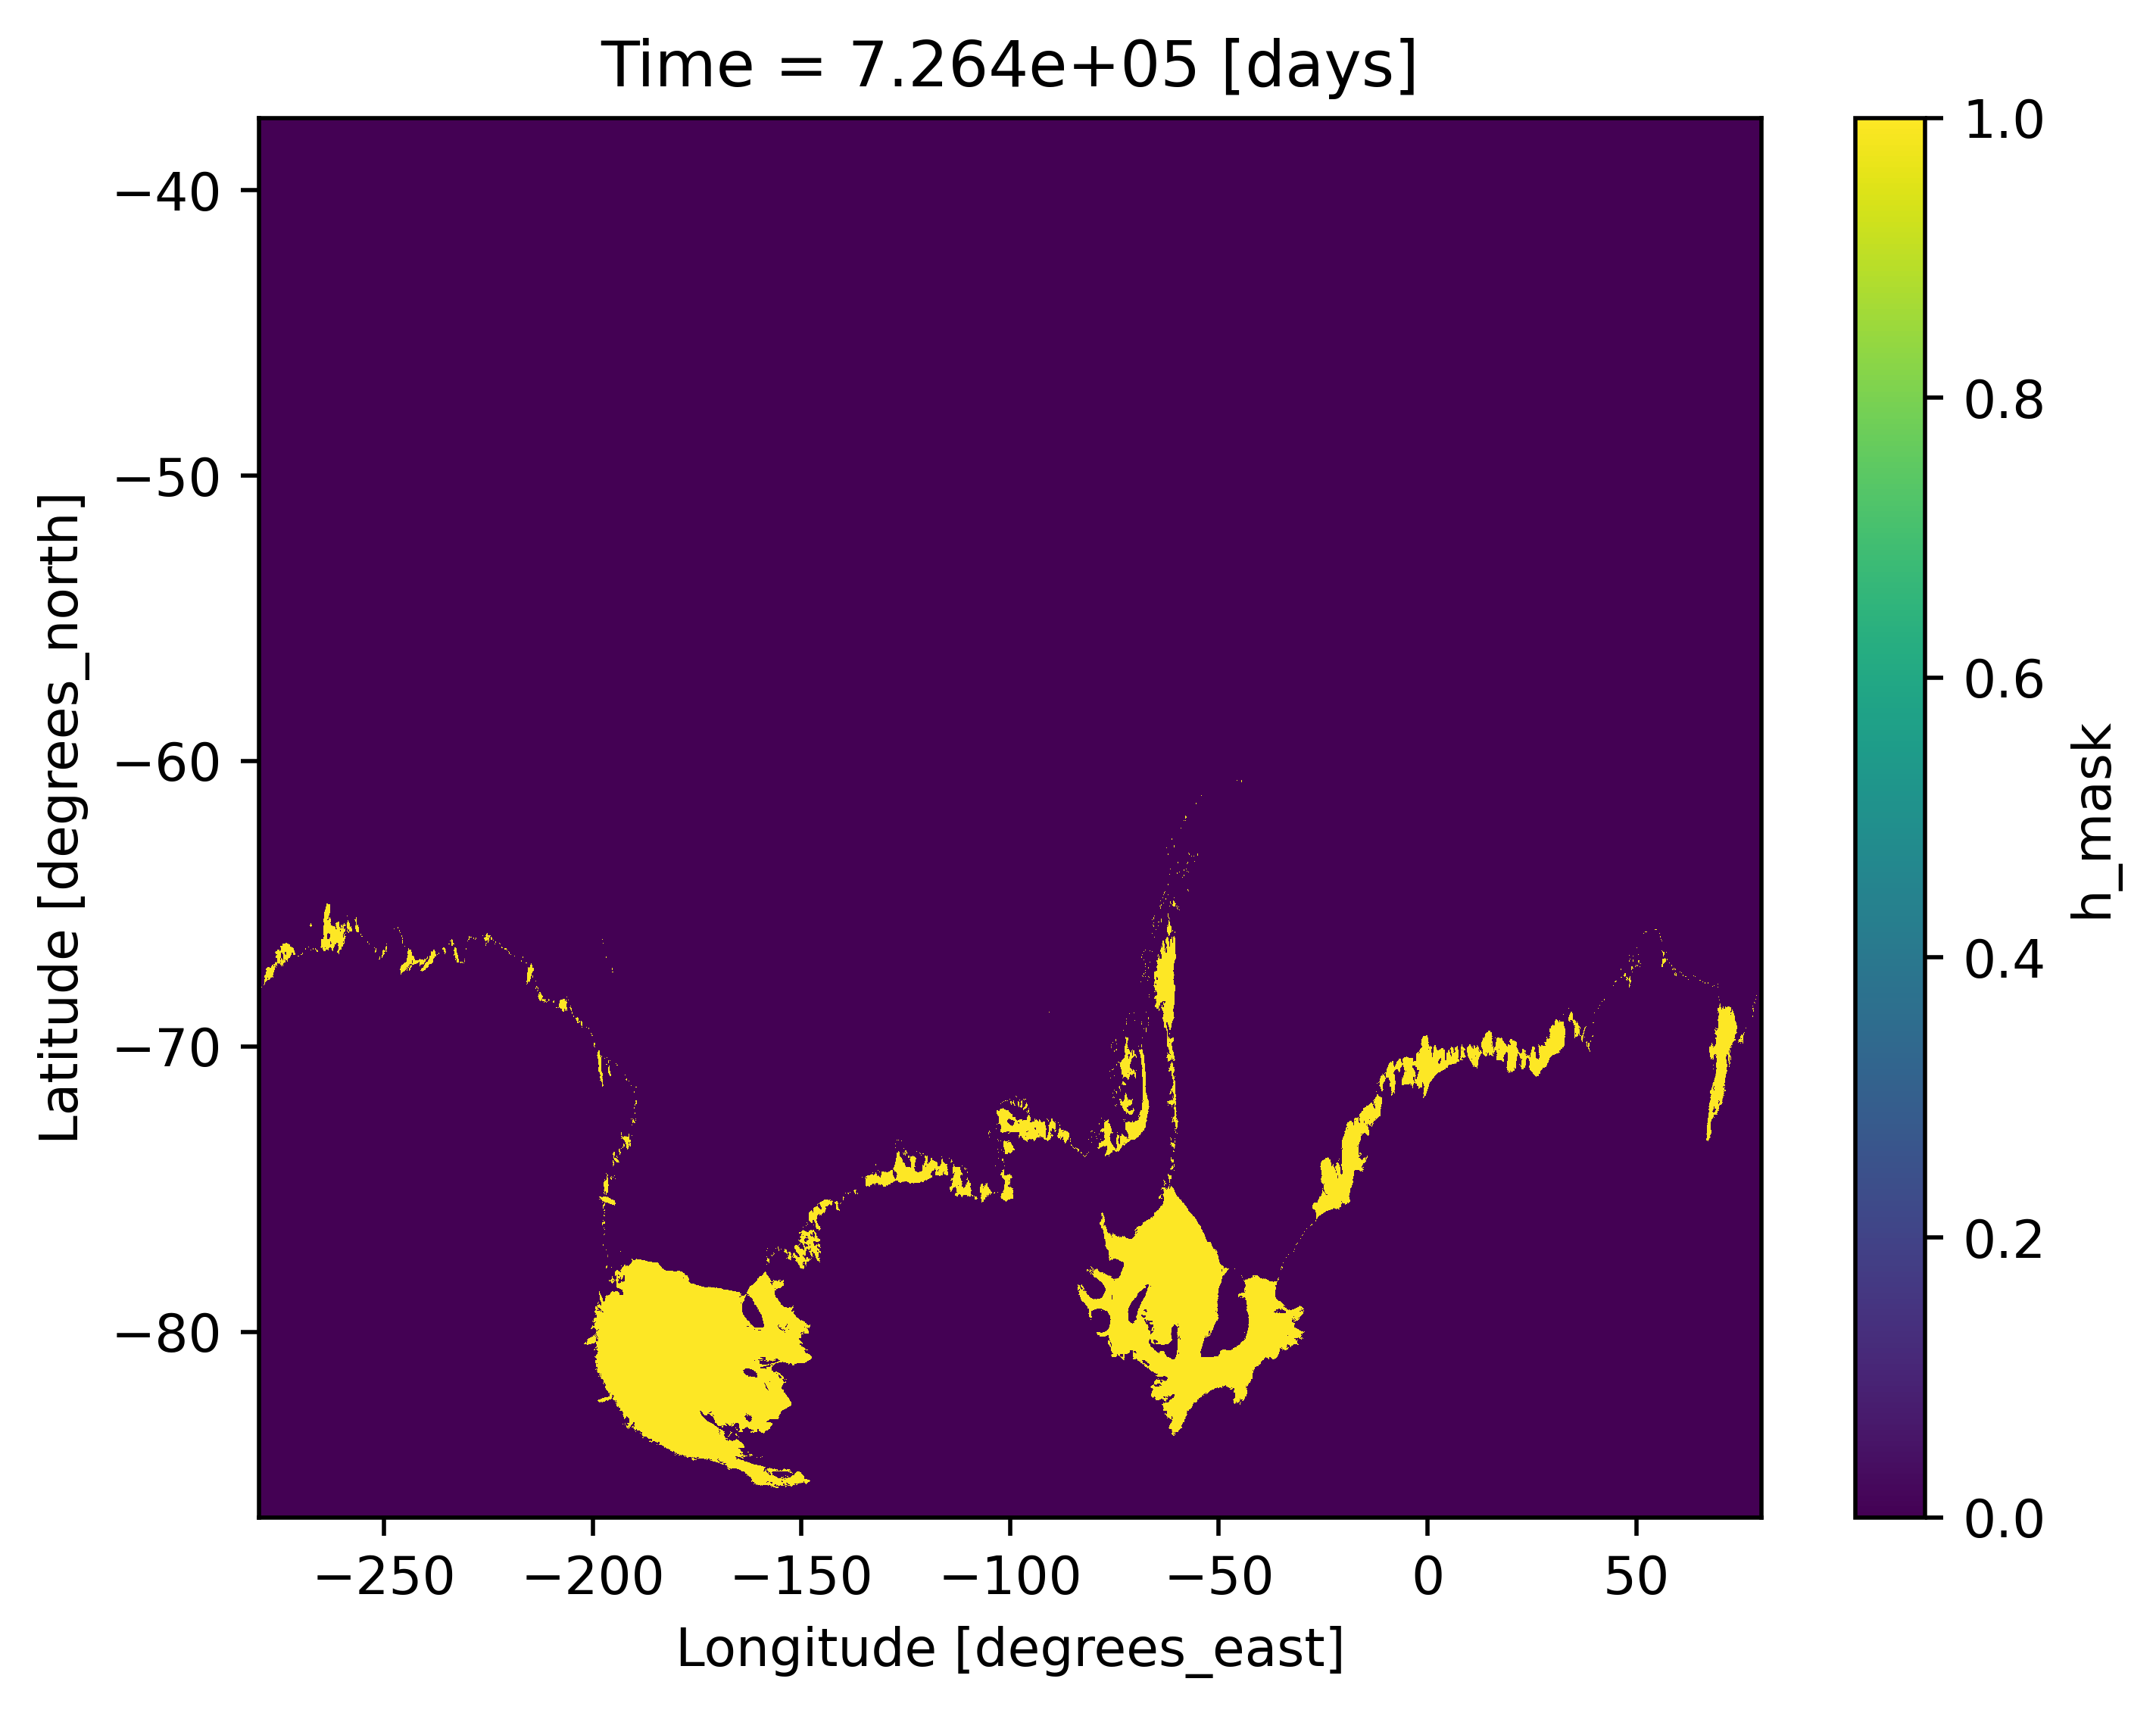

In [21]:
ice_thick_area_GL = ice_thick.copy().sel(ny = np.arange(1442))
ice_thick_area_GL["area"] = area.Ah.rename({'lath':'ny','lonh':'nx'}).where(surface.elevation.sel(ny = np.arange(1442))>0).fillna(0)
ice_thick_area_GL["area"] = ice_thick_area_GL.area.where(topo.depth>0).fillna(0)
ice_thick_area_GL["h_mask"] = (area.Ah.rename({'lath':'ny','lonh':'nx'}).where(surface.elevation.sel(ny = np.arange(1442))>0)*0+1).fillna(0)
ice_thick_area_GL["h_mask"] = ice_thick_area_GL.h_mask.where(topo.depth>0).fillna(0)
ice_thick_area_GL["thick"] = ice_thick_area_GL.thick.where(topo.depth>0).fillna(0)
ice_thick_area_GL["thick"] = ice_thick_area_GL.thick + (ice_thick_area_GL.thick.where((ice_thick_area_GL.thick ==0) & (ice_thick_area_GL.h_mask ==1))*0+1e-6).fillna(0)

fig = plt.figure(dpi = 500)
ice_thick_area_GL.area.plot()
plt.show()
fig = plt.figure(dpi = 500)
ice_thick_area_GL.thick.plot()
plt.show()
fig = plt.figure(dpi = 500)
ice_thick_area_GL.h_mask.plot()
plt.show()

ice_thick_area_GL.to_netcdf("/g/data/x77/cy8964/mom6/input/input-8km-SIS2/ice_thickness_Charrassin_regridded_cropped_add_area_where_iceelev_noGL5m_ADDHMASKFILLTHICK_190825.nc")


-2.94429087638855


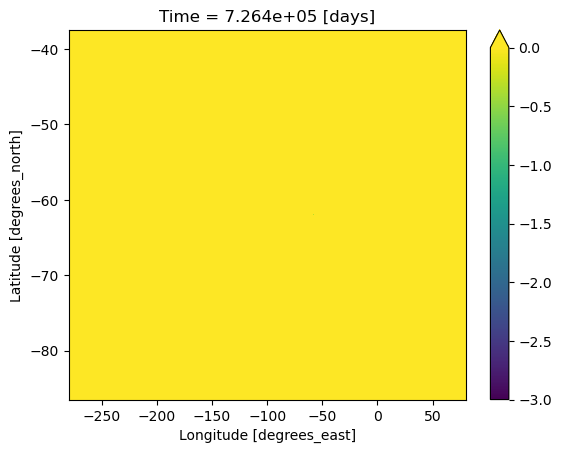

In [60]:
(topog_noGL.depth - 917/1035*ice_thick_area_GL.thick).plot(vmax = 0, vmin = -3)
print((topog_noGL.depth - 917/1035*ice_thick_area_GL.thick).min().values)

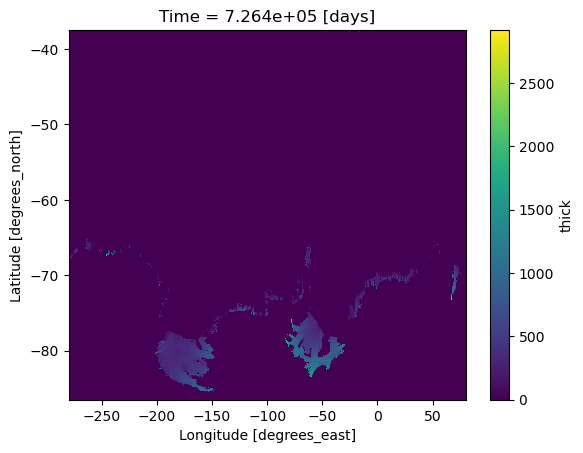

In [55]:
ice_thick_area_GL.thick.plot()

# need to regenerate mask? maybe?

To get this to initalise in ALE mode needed TRIMMING_USES_REMAPPING and the FRAC_DP bugfix

In [3]:
# improve metadata

topo_GL = xr.open_dataset('/g/data/x77/cy8964/mom6/input/input-8km-SIS2/topog_Charrassin_open_cavity_noGL5m_new190825.nc',
                      decode_timedelta = False)
topog_sea_ice_GL = xr.open_dataset("/g/data/x77/cy8964/mom6/input/input-8km-SIS2/topog_Charrassin_sea_ice_from_iceelev_no_edits_new190825.nc",
                                  decode_timedelta = False)

ice_thick_area_GL = xr.open_dataset("/g/data/x77/cy8964/mom6/input/input-8km-SIS2/ice_thickness_Charrassin_regridded_cropped_add_area_where_iceelev_noGL5m_ADDHMASKFILLTHICK_190825.nc",
                                   decode_timedelta = False)


In [7]:
topo_GL.attrs = {'description': 'Charrassin 2025 depth regridded onto global 1/12th (8km) grid, filled elsewhere with GEBCO 2024 data. Generated with notebook https://github.com/claireyung/mom6-panAn-iceshelf-tools/blob/add_charrassin_bathy/generate-draft/Generate-Charrassin-bathy.ipynb. Then processed to remove grounded ice and enforce a minimum ocean thickness of 5m according to initial conditions in https://github.com/claireyung/mom6-panAn-iceshelf-tools/blob/generate-draft/process-topo-8k-minimal.ipynb. No water column min/max applied, no topo edits and no isolated seas removal.'}
topo_GL.to_netcdf('/g/data/x77/cy8964/mom6/input/input-8km/topog_Charrassin_open_cavity_noGL5m_new190825.nc')


In [9]:
topog_sea_ice_GL.attrs = {'description':'Charrassin 2025 depth regridded onto global 1/12th (8km) grid, filled elsewhere with GEBCO 2024 data. Generated with notebook https://github.com/claireyung/mom6-panAn-iceshelf-tools/blob/add_charrassin_bathy/generate-draft/Generate-Charrassin-bathy.ipynb.  Then processed to remove grounded ice and enforce a minimum ocean thickness of 5m according to initial conditions in https://github.com/claireyung/mom6-panAn-iceshelf-tools/blob/generate-draft/process-topo-8k-minimal.ipynb. No water column min/max applied, no topo edits and no isolated seas removal. Set to zero where ice surface elevation > 0.'}
topog_sea_ice_GL.to_netcdf("/g/data/x77/cy8964/mom6/input/input-8km/topog_Charrassin_sea_ice_from_iceelev_no_edits_new190825.nc")


In [11]:
ice_thick_area_GL.attrs = {'description':'Ice thickness (meters), float, 0 to 5000 meters. From Charrassin 2025 depth regridded onto 8km grid, filled elsewhere with GEBCO 2024 data. Generated with notebook https://github.com/claireyung/mom6-panAn-iceshelf-tools/blob/add_charrassin_bathy/generate-draft/Generate-Charrassin-bathy.ipynb. Area added using ocean_geometry output of test ocean with depth 6000m. Then processed to remove grounded ice and enforce a minimum ocean thickness of 5m according to initial conditions in https://github.com/claireyung/mom6-panAn-iceshelf-tools/blob/generate-draft/process-topo-8k-minimal.ipynb. Thickness filled to be 1e-6 where thick=0 but elevation > 0. h_mask and area uses where elevation > 0.'}
ice_thick_area_GL.to_netcdf("/g/data/x77/cy8964/mom6/input/input-8km/ice_thickness_Charrassin_regridded_cropped_add_area_where_iceelev_noGL5m_ADDHMASKFILLTHICK_190825.nc")


In [13]:
mask_sea_ice = topog_sea_ice_GL.copy()
mask_sea_ice["kmt"] = mask_sea_ice.depth.where(mask_sea_ice.depth>0)*0+1
mask_sea_ice = mask_sea_ice.drop("depth")
mask_sea_ice.attrs = {'description': 'Charrassin 2025 depth regridded onto global 1/12th (8km) grid, filled elsewhere with GEBCO 2024 data. Generated with notebook https://github.com/claireyung/mom6-panAn-iceshelf-tools/blob/add_charrassin_bathy/generate-draft/Generate-Charrassin-bathy.ipynb.  Then processed to remove grounded ice and enforce a minimum ocean thickness of 5m according to initial conditions in https://github.com/claireyung/mom6-panAn-iceshelf-tools/blob/generate-draft/process-topo-8k-minimal.ipynb. No water column min/max applied, no topo edits and no isolated seas removal. Set to zero where ice surface elevation > 0. Masked to find kmt with nonzero values.'}
mask_sea_ice.to_netcdf("/g/data/x77/cy8964/mom6/input/input-8km/kmt_Charrassin_sea_ice_from_iceelev_no_edits_new190825.nc")

/jobfs/147771340.gadi-pbs/ipykernel_1583890/55828583.py:3: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  mask_sea_ice = mask_sea_ice.drop("depth")


In [4]:
mask_sea_ice = topog_sea_ice_GL.copy()
mask_sea_ice["mask"] = mask_sea_ice.depth.where(mask_sea_ice.depth>0)*0+1
mask_sea_ice = mask_sea_ice.drop("depth")
mask_sea_ice.attrs = {'description': 'Charrassin 2025 depth regridded onto global 1/12th (8km) grid, filled elsewhere with GEBCO 2024 data. Generated with notebook https://github.com/claireyung/mom6-panAn-iceshelf-tools/blob/add_charrassin_bathy/generate-draft/Generate-Charrassin-bathy.ipynb.  Then processed to remove grounded ice and enforce a minimum ocean thickness of 5m according to initial conditions in https://github.com/claireyung/mom6-panAn-iceshelf-tools/blob/generate-draft/process-topo-8k-minimal.ipynb. No water column min/max applied, no topo edits and no isolated seas removal. Set to zero where ice surface elevation > 0. Masked to find mask with nonzero values.'}
mask_sea_ice.to_netcdf("/g/data/x77/cy8964/mom6/input/input-8km/mask_Charrassin_sea_ice_from_iceelev_no_edits_new190825.nc")

/jobfs/147778973.gadi-pbs/ipykernel_439582/989154839.py:3: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  mask_sea_ice = mask_sea_ice.drop("depth")
